Sliding Window: https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from datetime import datetime, timedelta
from pykrx import stock
import random
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch import optim
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from collections import Counter
from scipy.spatial.distance import squareform, pdist
import joblib

In [2]:
import matplotlib as mpl
import matplotlib.font_manager
[f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# 유니코드 깨짐 현상 해결
mpl.rcParams['axes.unicode_minus'] = False
# 나눔 고딕 폰트 적용
mpl.rcParams['font.family'] = 'NanumGothic'

# 1. 함수

## 슬라이딩 윈도우 설정

In [3]:
## window dataset을 생성하는 클래스
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, stride):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window*30, num_samples])
        Y = np.zeros([output_window*30, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x].reshape(1, -1).flatten()

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y].reshape(1, -1).flatten()

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y     
        self.len = len(X)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

input window, output window, stride를 입력받고 iw + ow만큼의 길이를 stride 간격으로 sliding하면서 데이터셋을 생성  
결과의 첫 번째 값으로는 input, 두 번째 값으로는 output이 출력

## 모델링

### 모델 함수 구현

* encoder: input을 통해 decoder에 전달할 hidden state 생성
* decoder: input의 마지막 값과 encoder에서 받은 hidden state를 이용하여 한 개의 값을 예측
* encoder decoder: 위의 두 모델을 합침. 원하는 길이의 아웃풋이 나올 때까지 decoder를 여러번 실행시켜서 최종 output을 생성. 원할한 학습을 위해 decoder의 input으로 실제 값을 넣는 teach forcing 구현

In [4]:
## input으로부터 입력을 받고 lstm을 이용하여 디코더에 전달할 hidden state 생성
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [5]:
## sequence의 이전값 하나와, 이전 결과의 hidden state를 입력받아서 다음 값 하나를 예측
## 마지막에 fc layer를 연결해서 input size와 동일하게 크기를 맞춰줌
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [6]:
## 위의 두 모델 합치기
## 인코더를 한 번 실행시키고 인코더에서 전달받은 hidden state와 input의 마지막 값을 decoder에 전달해서 다음 예측값을 구함
## 여기서 나온 값과 hidden state를 반복적으로 사용해서 원하는 길이가 될 때까지 decoder 실행
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len*30, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        #원하는 길이가 될 때까지 decoder를 실행한다.
        for t in range(target_len*30): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out
        return outputs

    # 편의성을 위해 예측해주는 함수도 생성한다.
    def predict(self, inputs, target_len):
        self.eval()
        inputs = inputs.unsqueeze(0)
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len*30, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len*30): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

### 모델 학습

In [7]:
device = torch.device('cpu')

In [8]:
def train(train_loader, ow):
    model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
    
    learning_rate=0.01
    epoch = 3000
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.MSELoss()
    
    model.train()
    loss_avgs = []
    with tqdm(range(epoch)) as tr:
        for i in tr:
            total_loss = 0.0
            tf_ratio = max(0.6 - i*0.0001, 0)  # 0.6에서 teacher forcing을 점진적으로 줄여나감
#             tf_ratio = 0.6  # tf 조정 없이 0.6으로 통일할 때 사용
            for x,y in train_loader:
                optimizer.zero_grad()
                x = x.to(device).float()
                y = y.to(device).float()
                output = model(x, y, ow, tf_ratio).to(device)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.cpu().item()
            tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))
            loss_avgs.append(total_loss/len(train_loader))
    return model, loss_avgs

## 최종 예측 모델 함수

In [9]:
def forecasting_model(df, iw, ow, st):
    print('iw='+str(iw), 'ow='+str(ow), 'st='+str(st))

    ## 데이터 스케일링
    ## 데이터 분할
    # 마지막 일주일의 데이터를 예측하는 것이 목표
    scaler = MinMaxScaler()
    train_data = np.array(df)
    scaler.fit(train_data)
    train_np = scaler.transform(train_data)

    ## 슬라이딩 윈도우 설정
    df_train_dataset = windowDataset(train_np, input_window=iw, output_window=ow, stride=st)
    df_train_loader = DataLoader(df_train_dataset, batch_size=256)

    ## 모델 학습
    df_model, loss_avg = train(df_train_loader, ow)

#     ## 모델 저장
#     joblib.dump(df_model, './result/final/model/out'+str(ow)+'/stride'+str(st)+'/'+str(iw)+'days_model.pkl')

#     ## 예측
#     device = torch.device('cpu')
#     df_predict = df_model.predict(torch.tensor(train_np).reshape(-1,1).to(device).float(), target_len=ow)
    
#     ## 예측값 저장
#     standard = pd.to_datetime('2023-01-01')
#     df_predict_df = pd.DataFrame(scaler.inverse_transform(df_predict.reshape(ow, 30)), columns=company, index=pd.date_range(standard, standard+timedelta(days=ow-1)))
#     df_predict_df.to_csv('./result/final/predict/out'+str(ow)+'/stride'+str(st)+'/'+str(iw)+'days.csv', encoding='cp949')
    return df_model, loss_avg

# 2. 데이터 적용

In [10]:
# ## 2013-01-01에 상장되어있는 종목
# tickers = stock.get_market_ticker_list("20130101", market='KOSPI')

# companys = []
# for ticker in tickers:
#     companys.append(stock.get_market_ticker_name(ticker))

# stocks_code = pd.DataFrame({'Code':tickers, 'Name':companys})
# stocks_code
# # 중간에 3개는 중복된 값이 있나봄

In [11]:
# start = '2013-01-01'
# end = '2022-12-31'
# df_stocks = pd.DataFrame(columns=['Date'])
# df_stocks['Date'] = pd.date_range(start, end)
# df_stocks.set_index('Date', inplace=True)
# for i in range(stocks_code.shape[0]):
#     df_stocks[stocks_code.Name.iloc[i]] = stock.get_market_ohlcv_by_date(start, end, stocks_code.Code.iloc[i])['종가']
# # df_stocks = df_stocks.interpolate().loc['2013-01-02':]  ## 결측치를 선형 비례한 값으로 채우기, 1월 1일은 여전히 결측값이므로 제외
# # df_stocks.to_csv('./source/stock_All.csv', encoding='cp949')
# df_stocks

In [12]:
df_stocks = pd.read_csv('./source/30/stocks_clustering30.csv', encoding='cp949')
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks.set_index(['Date'], inplace=True)
df_stocks = df_stocks.loc[:'2022-12-31']
df_stocks

,LG화학,삼천리,한샘,동부건설,이아이디,무학,삼성SDI우,한세실업,CJ씨푸드1우,일진다이아,...,영진약품,넥센,아모레퍼시픽,CJ제일제당,AK홀딩스,세아제강지주,현대차우,고려제강,현대지에프홀딩스,한국화장품
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,340000.000000,123500.0,18350.000000,74686.0,10869.0,13034.000000,50000.000000,16750.0,4970.0,6467.000000,...,1645.000000,7900.00,121031.0,362000.000000,21565.000000,78861.000000,68200.000000,18435.0,11032.0,2260.0
2013-01-03,342500.000000,121000.0,17600.000000,75109.0,10921.0,13129.000000,49800.000000,15700.0,4870.0,6467.000000,...,1675.000000,7730.00,121331.0,369000.000000,22292.000000,79032.000000,64500.000000,18496.0,10670.0,2255.0
2013-01-04,331000.000000,123000.0,18100.000000,77754.0,10972.0,13176.000000,50100.000000,15000.0,4975.0,6371.000000,...,1665.000000,7630.00,123532.0,375000.000000,22971.000000,78350.000000,66200.000000,18225.0,10703.0,2265.0
2013-01-05,329166.666667,123500.0,18183.333333,79235.0,10750.0,13128.666667,49916.666667,14850.0,4925.0,6393.333333,...,1673.333333,7590.00,123832.0,372666.666667,23003.333333,78321.666667,66333.333333,18285.0,10703.0,2305.0
2013-01-06,327333.333333,124000.0,18266.666667,80716.0,10528.0,13081.333333,49733.333333,14700.0,4875.0,6415.666667,...,1681.666667,7550.00,124132.0,370333.333333,23035.666667,78293.333333,66466.666667,18345.0,10703.0,2345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,628000.000000,379000.0,44400.000000,8030.0,925.0,5120.000000,290500.000000,16650.0,25100.0,16300.000000,...,3115.000000,4130.00,141500.0,384000.000000,17300.000000,162000.000000,80700.000000,20700.0,4782.0,8880.0
2022-12-28,602000.000000,409000.0,45450.000000,7520.0,898.0,5000.000000,284000.000000,15900.0,24900.0,17000.000000,...,3160.000000,4135.00,141000.0,388500.000000,17350.000000,160500.000000,76700.000000,20000.0,4610.0,8400.0
2022-12-29,600000.000000,391000.0,44600.000000,7260.0,862.0,4935.000000,277000.000000,15400.0,25850.0,16600.000000,...,3250.000000,4105.00,137500.0,380500.000000,17200.000000,146500.000000,74000.000000,19500.0,4433.0,8140.0


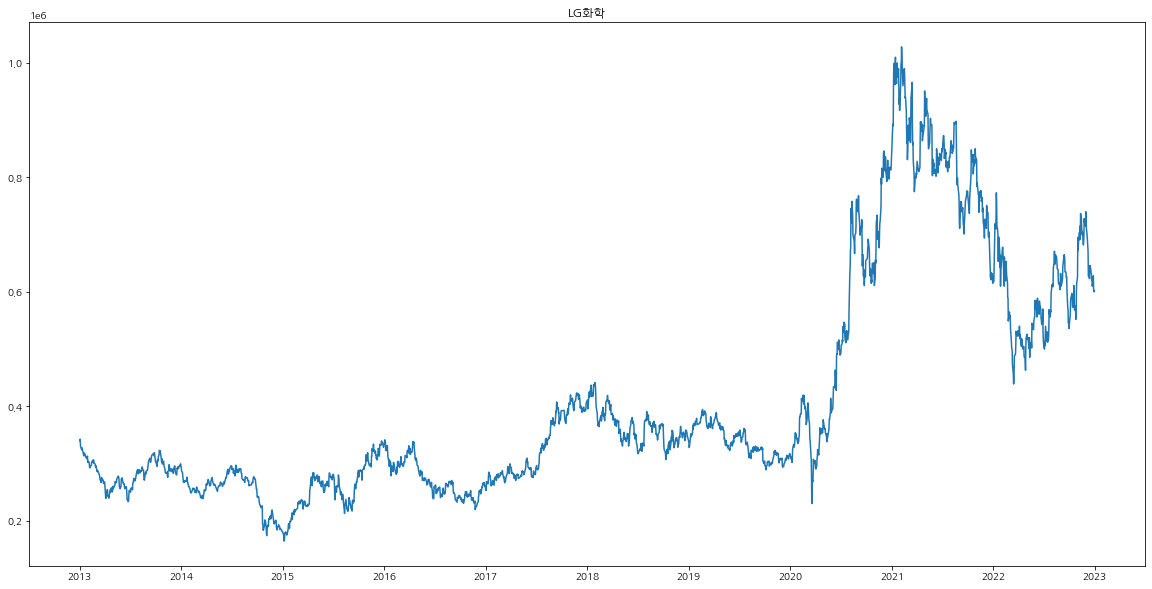

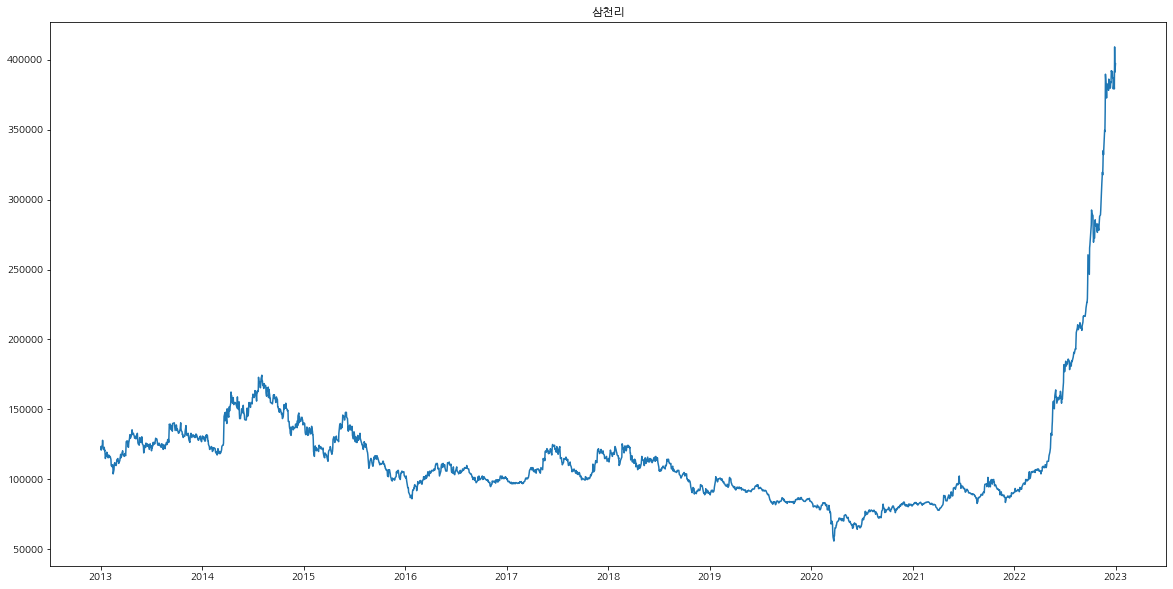

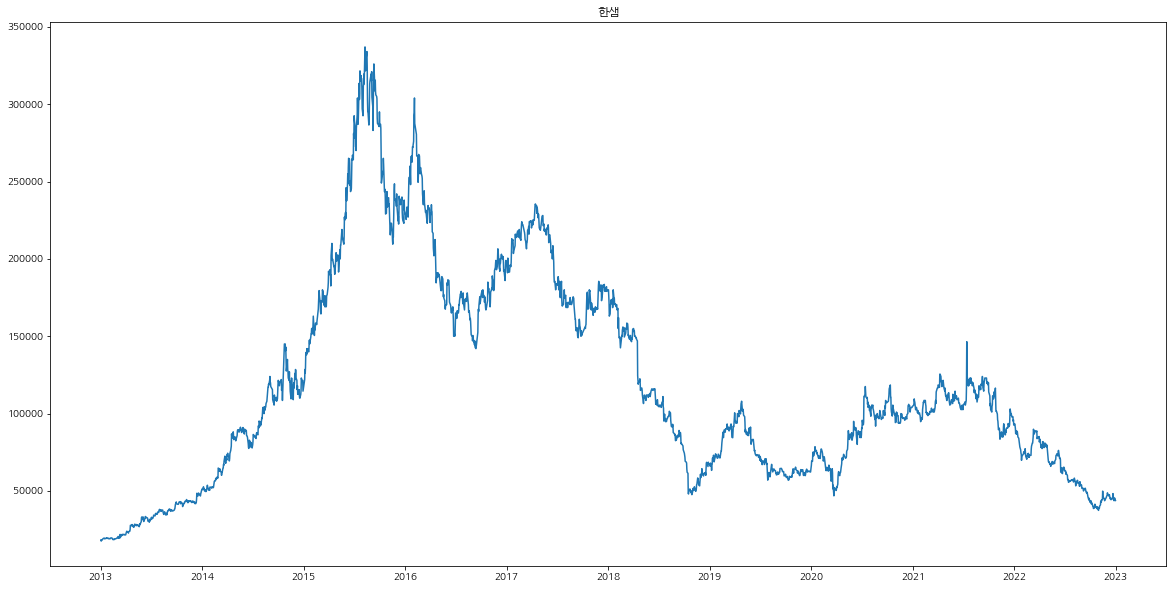

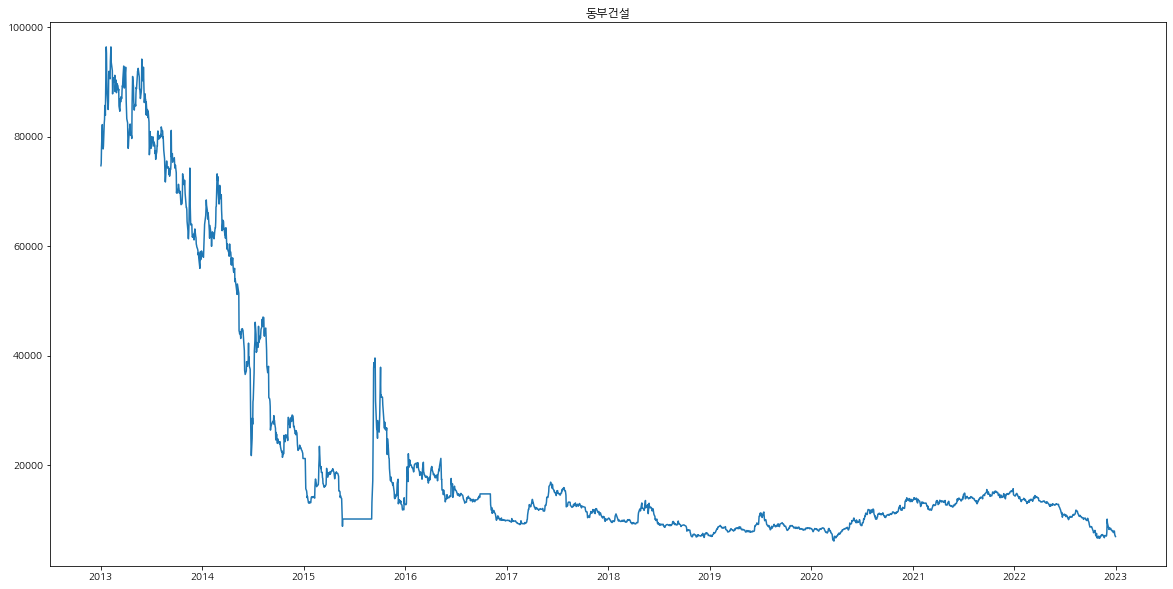

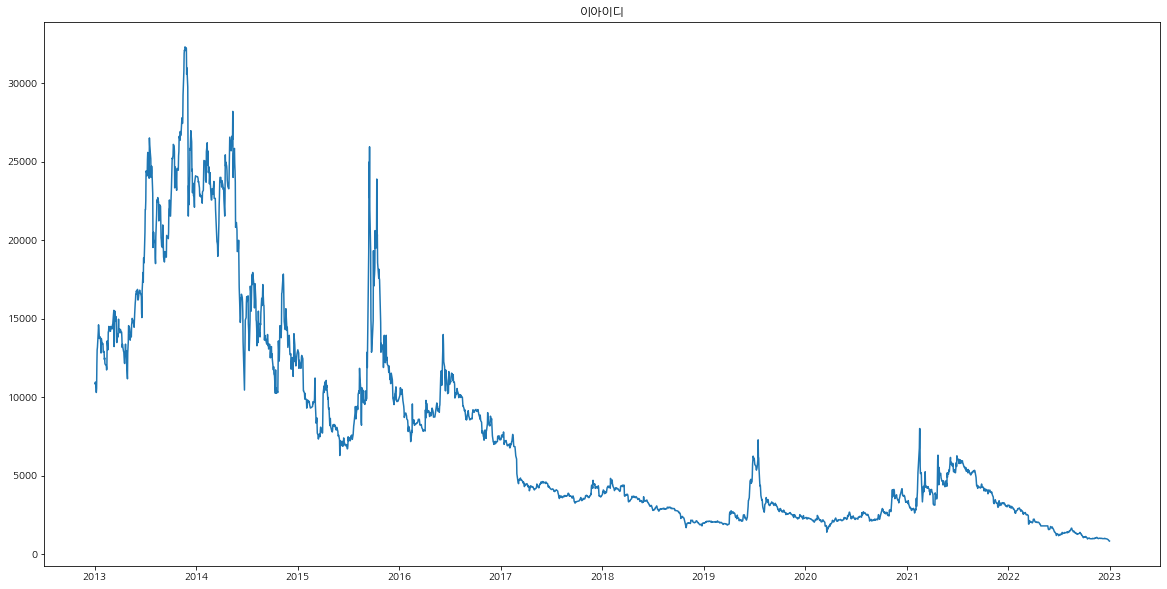

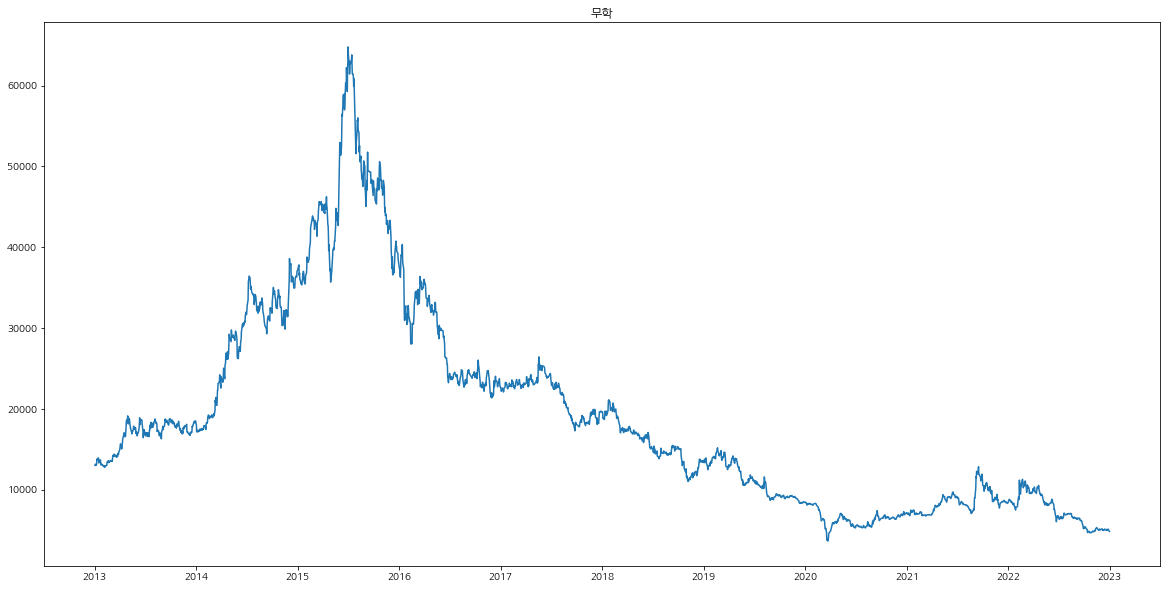

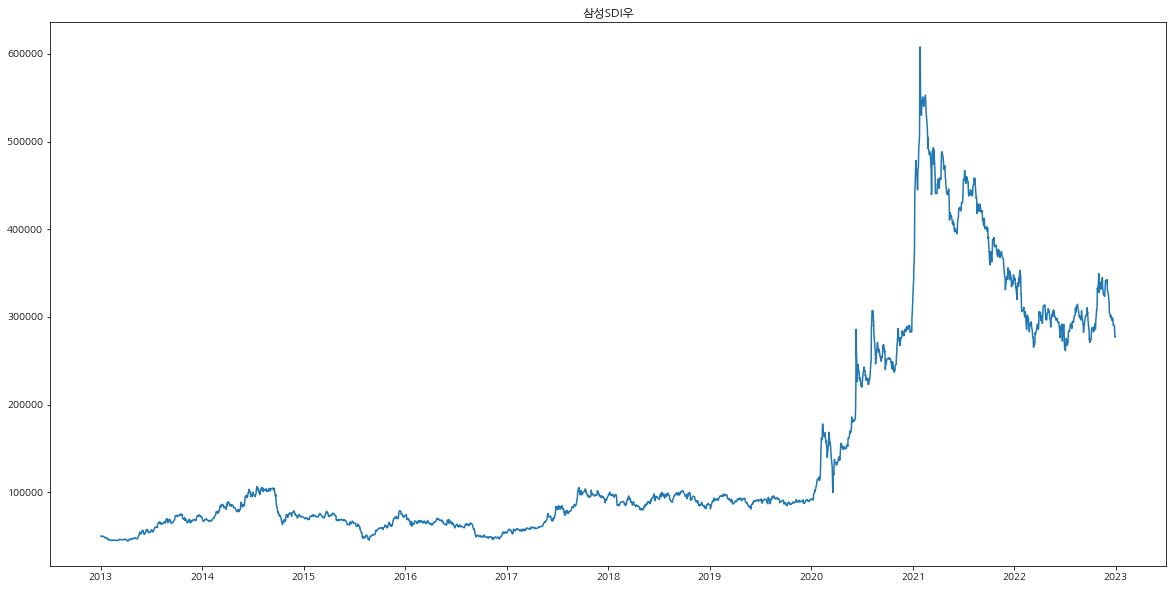

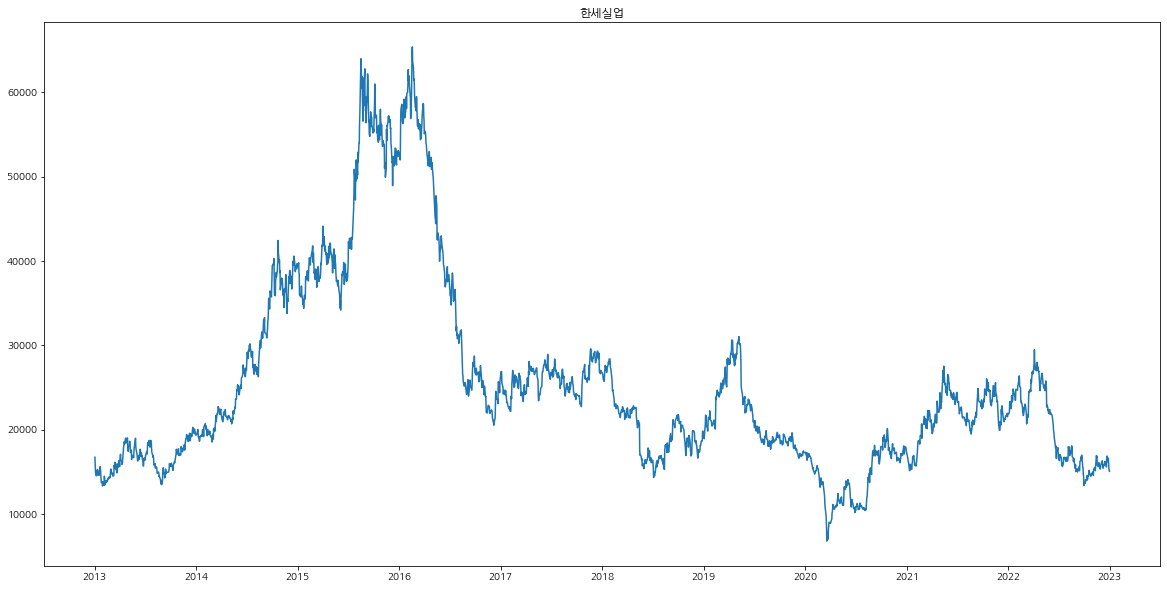

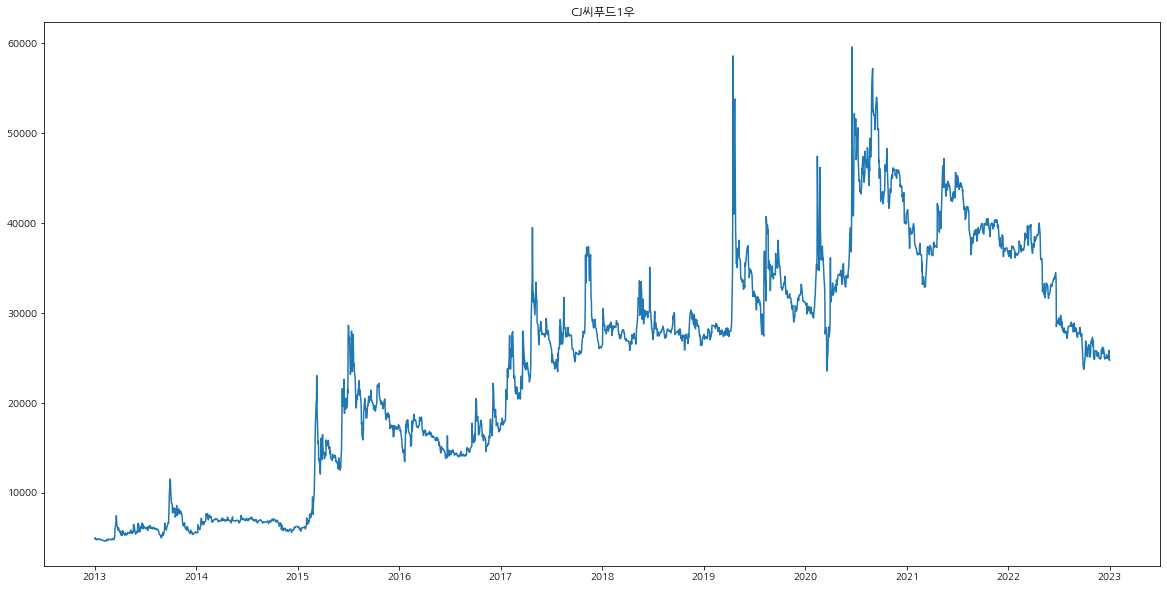

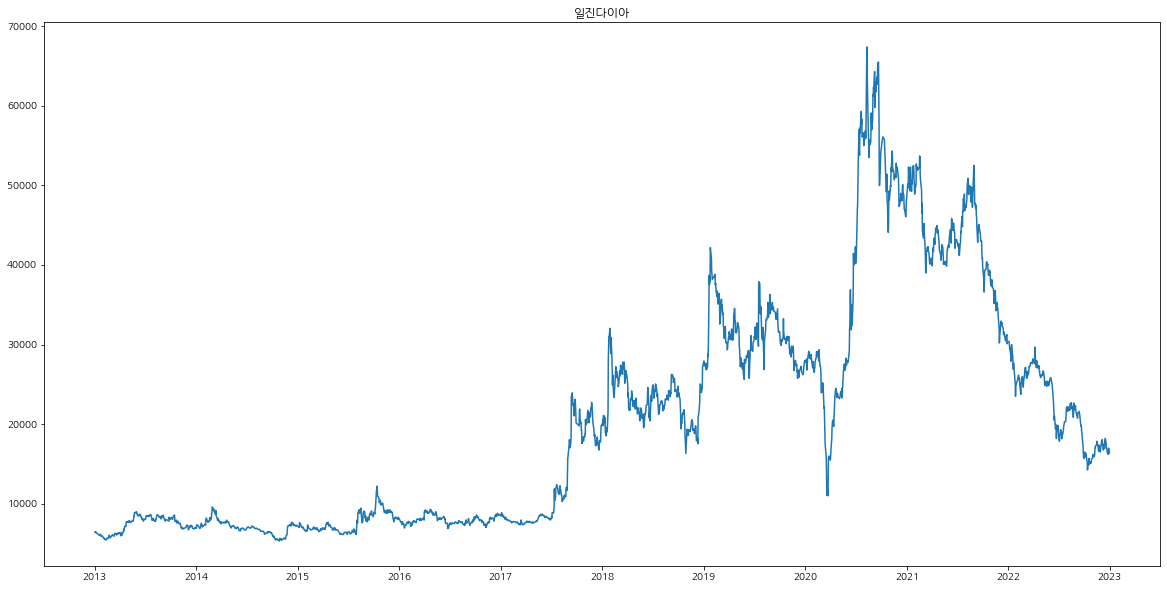

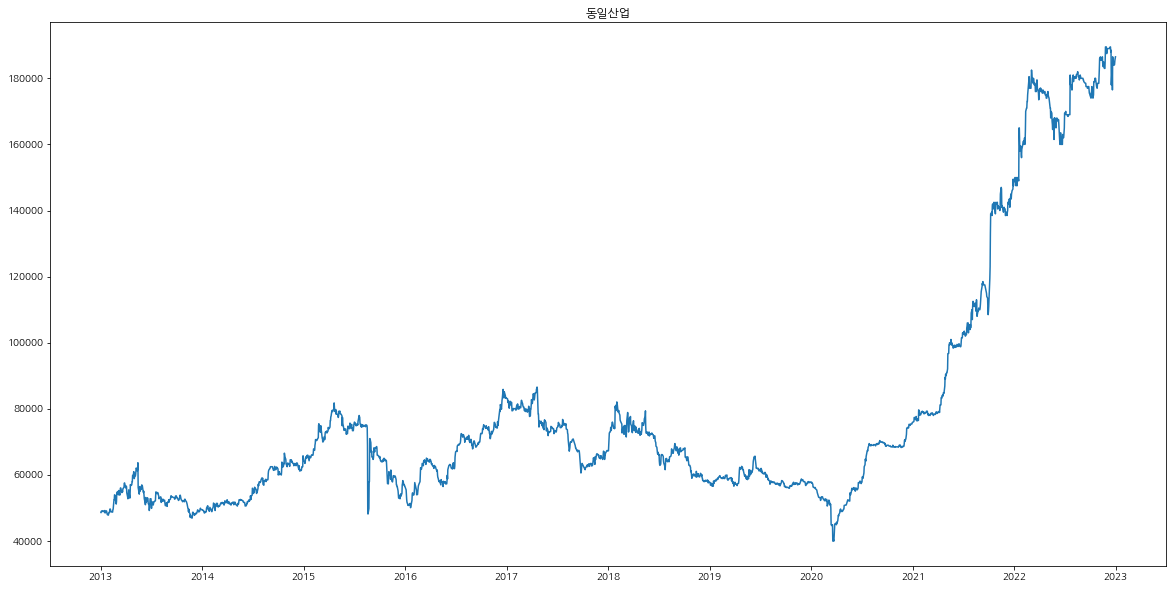

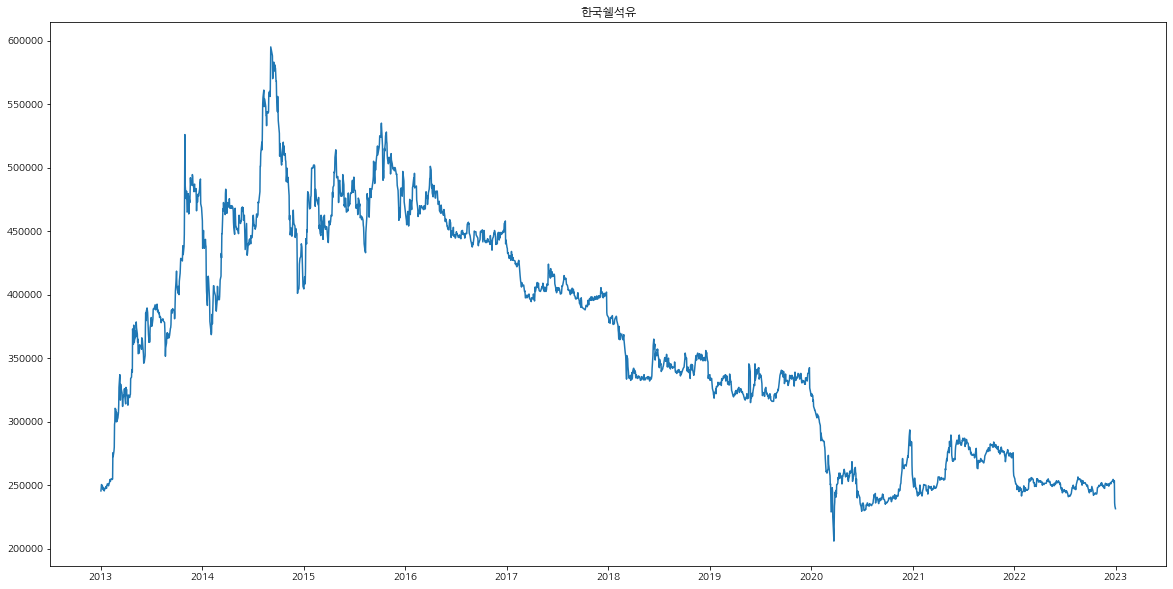

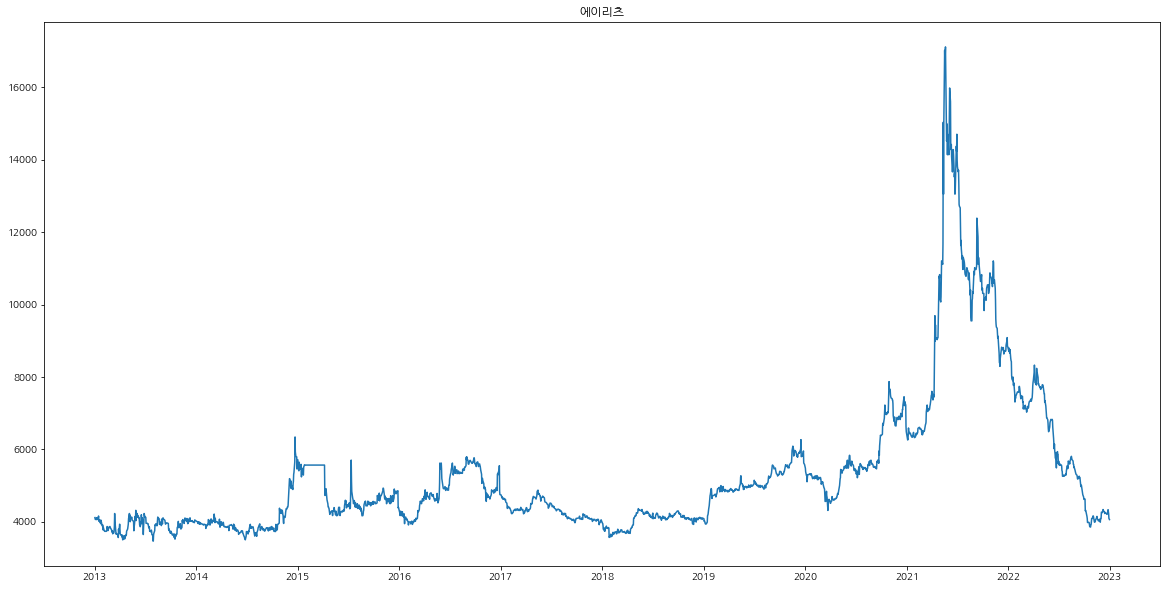

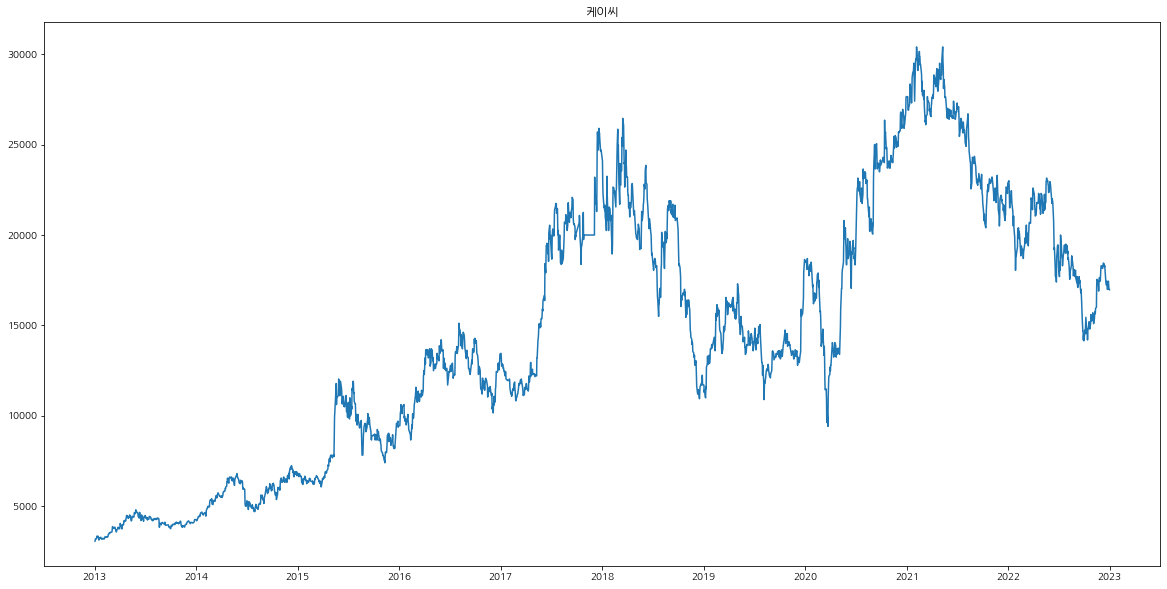

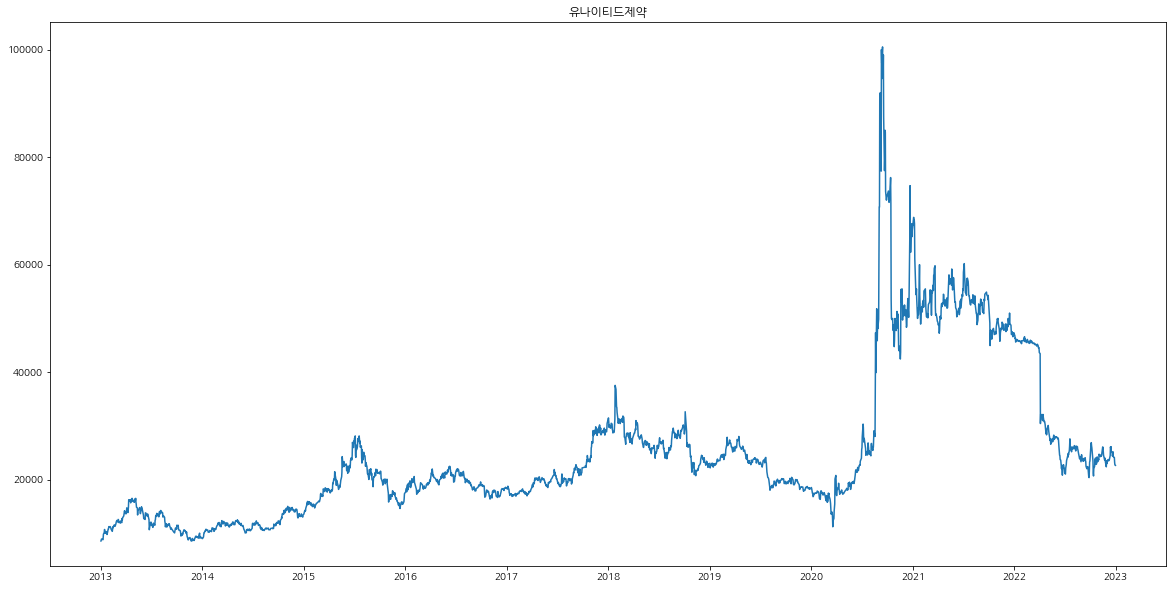

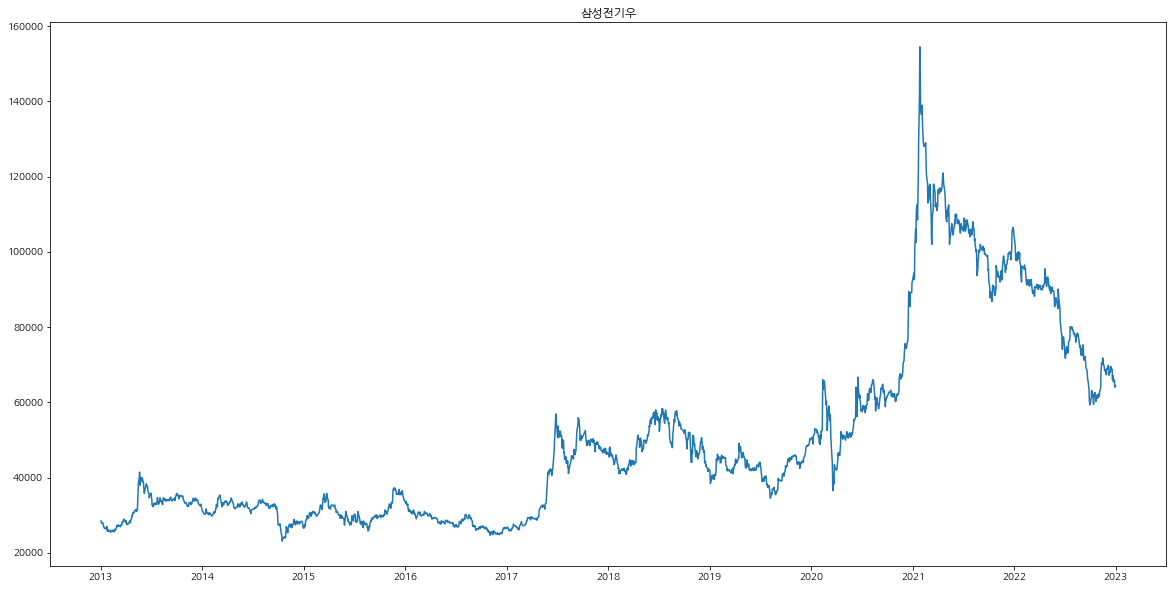

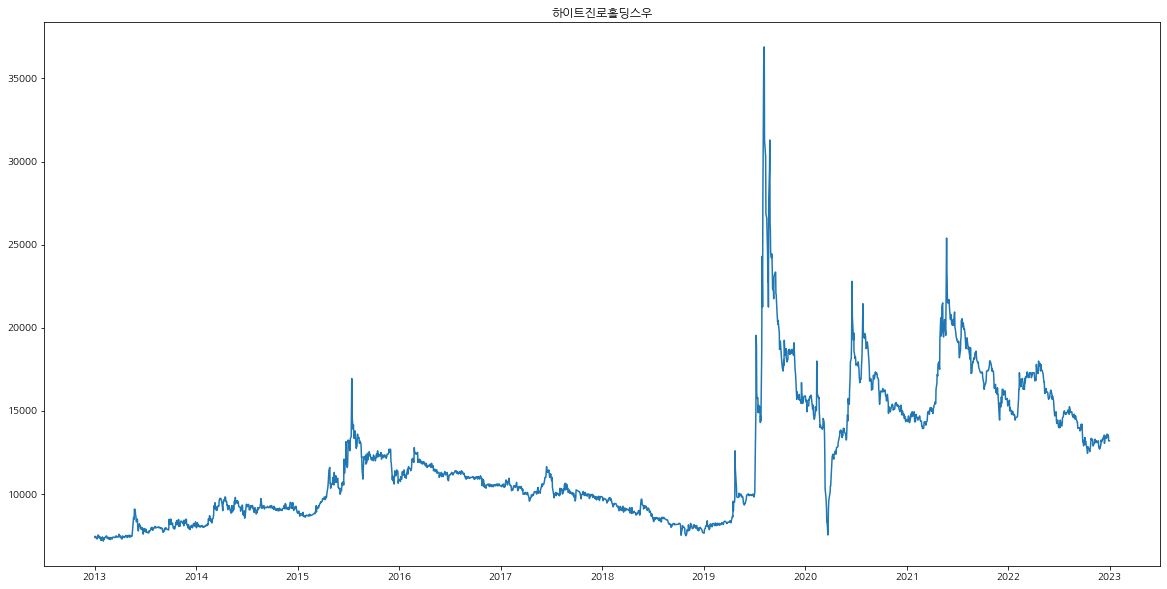

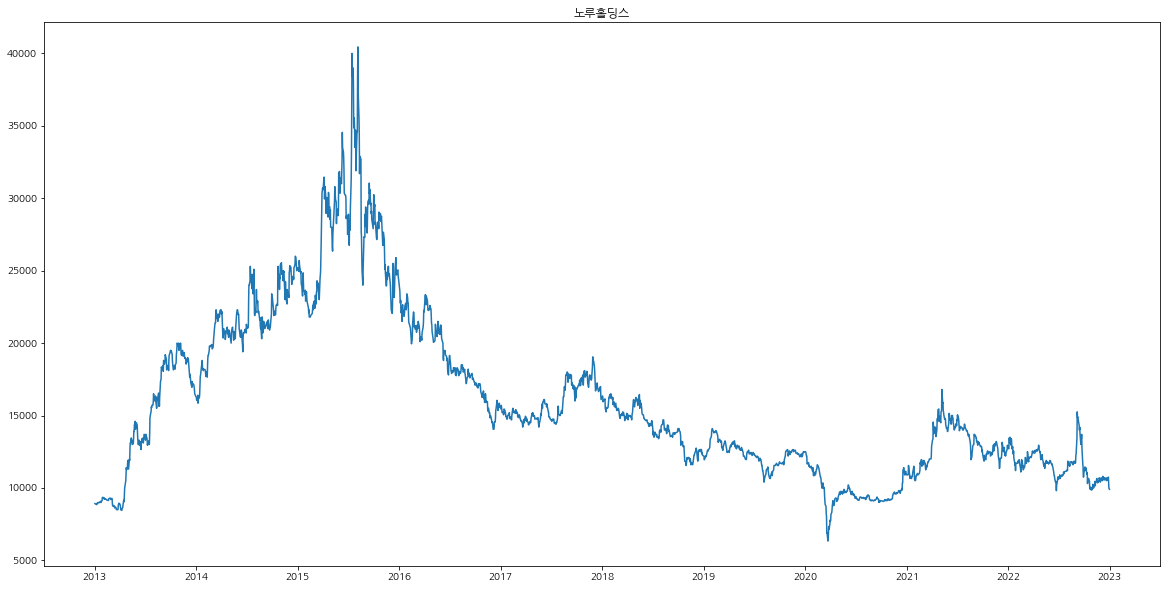

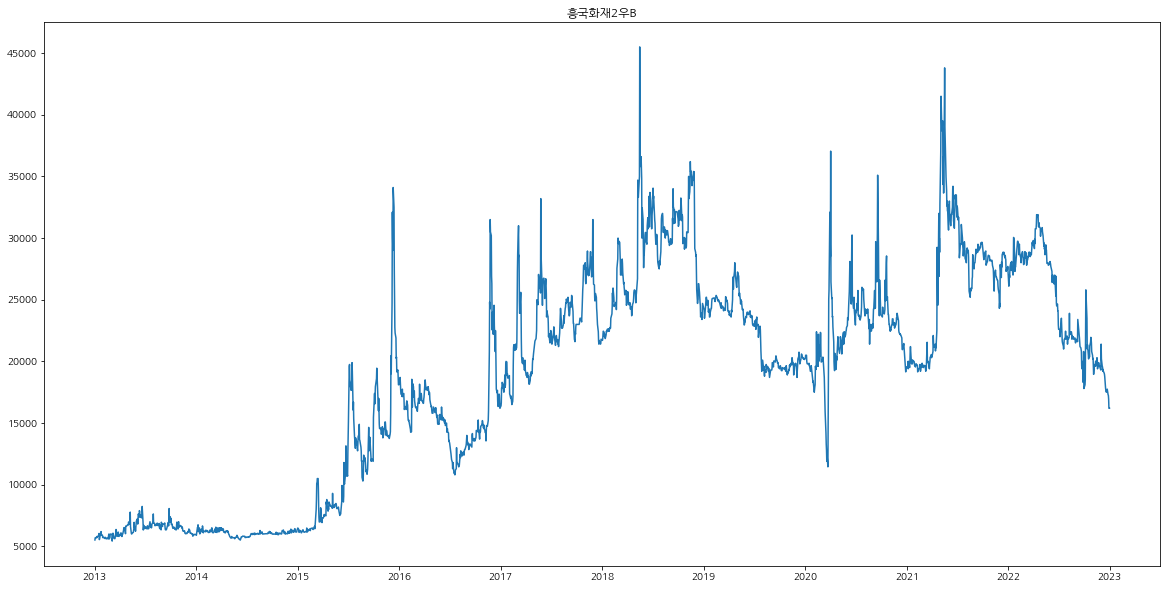

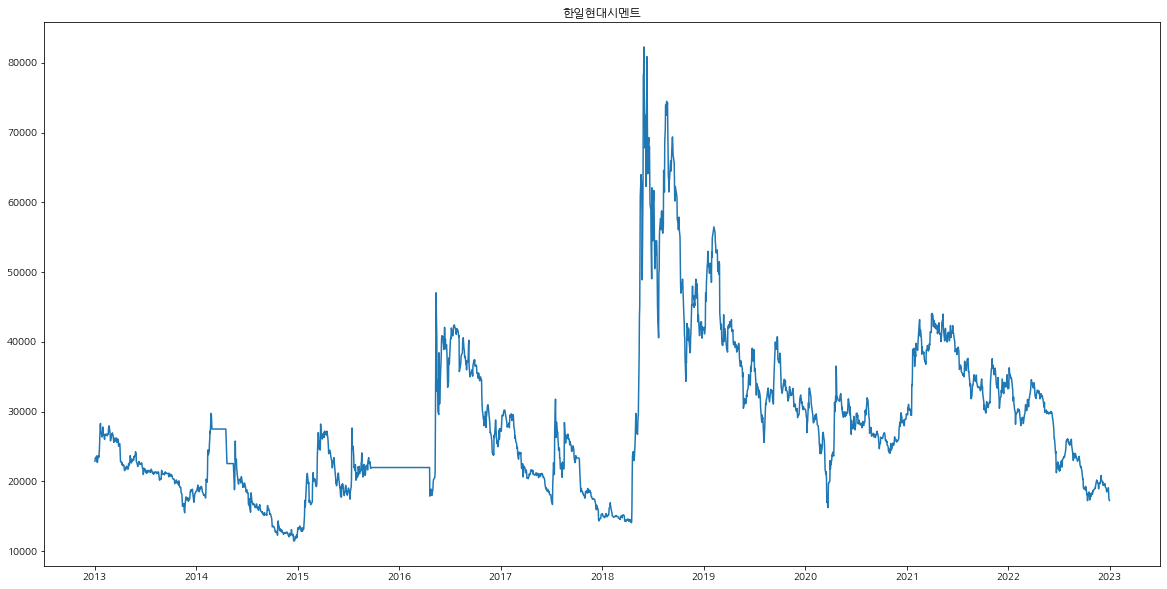

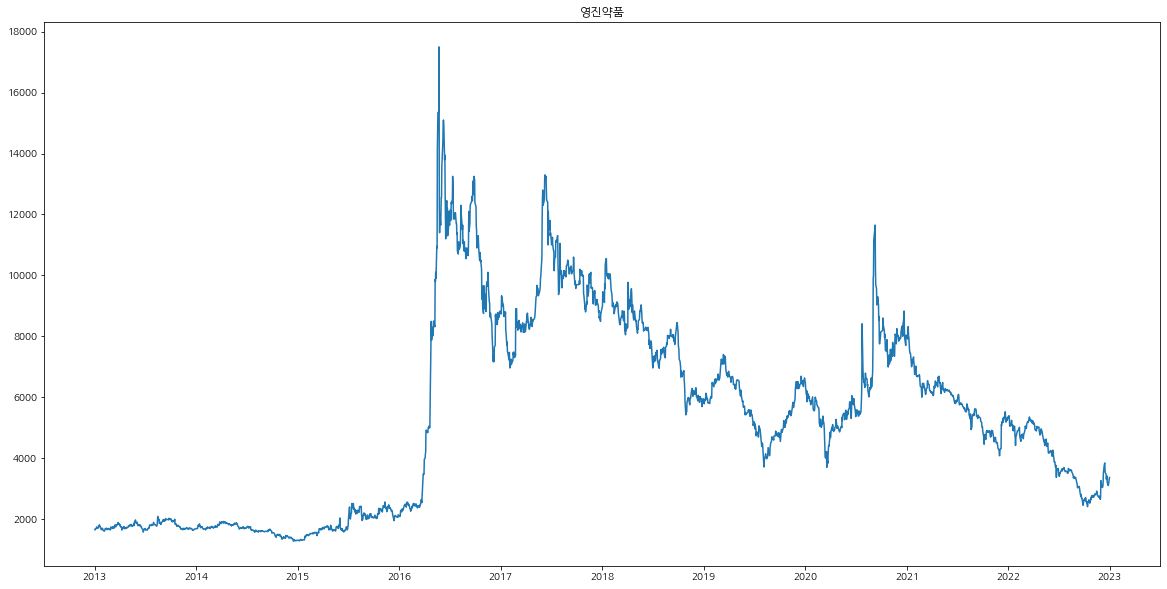

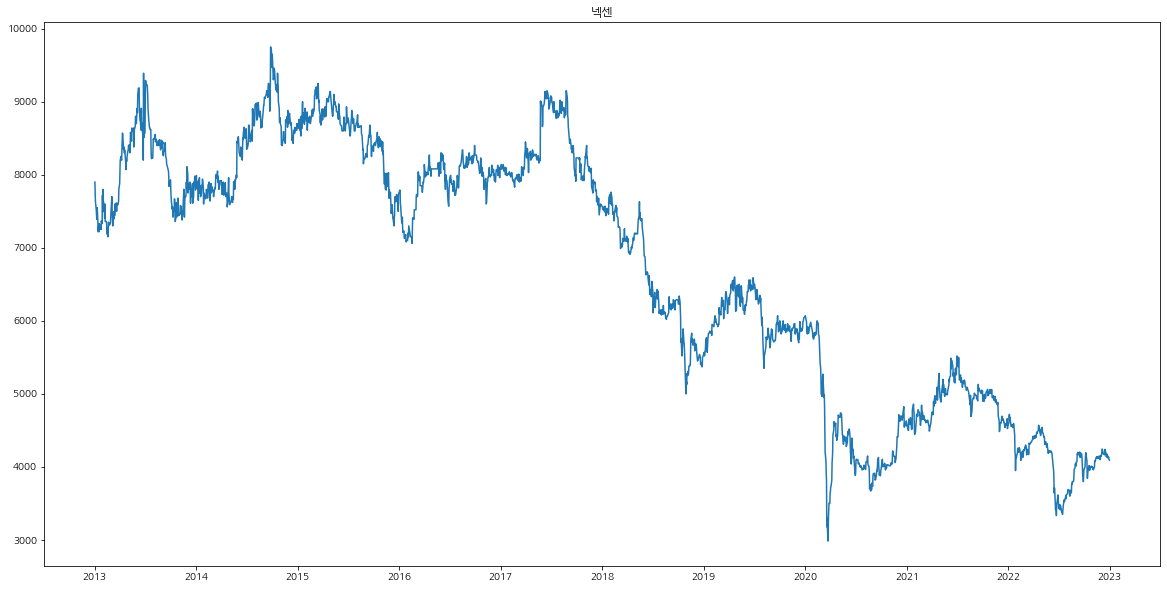

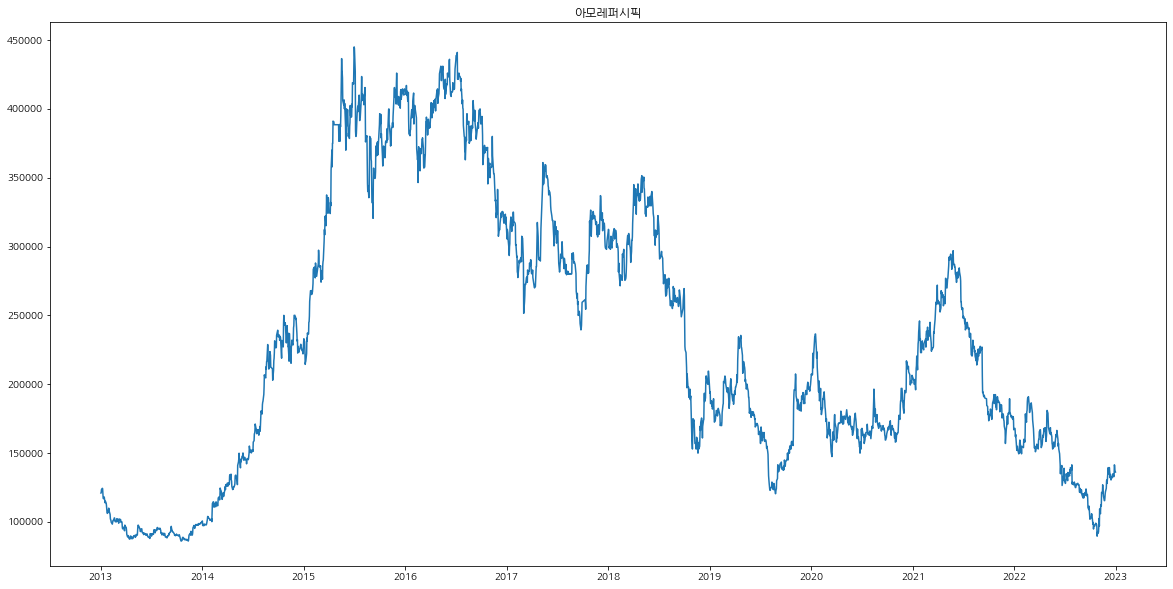

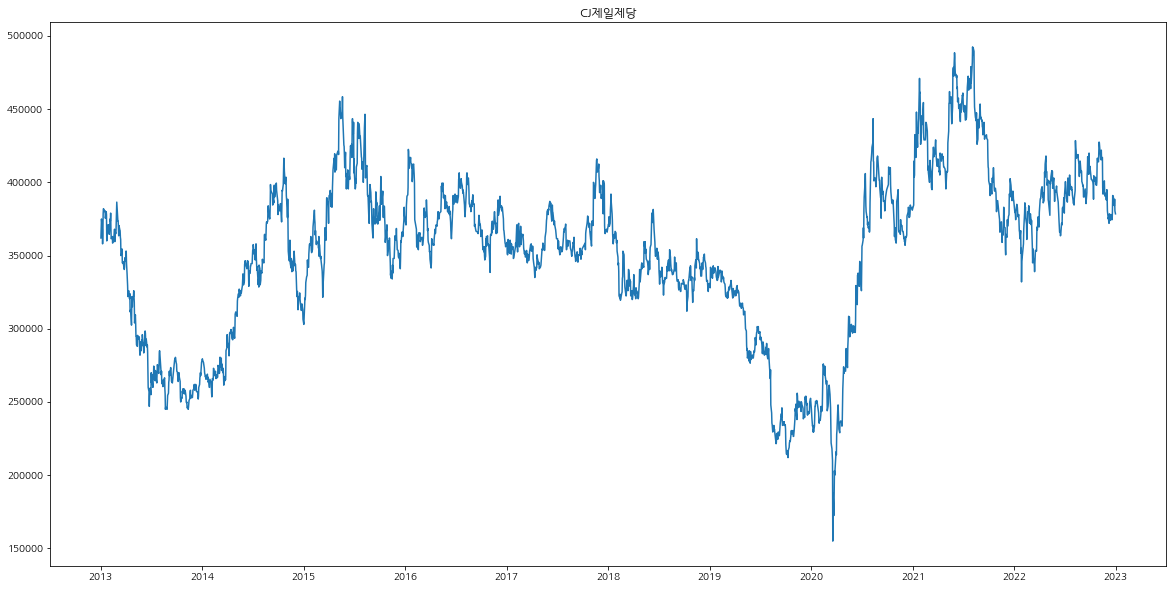

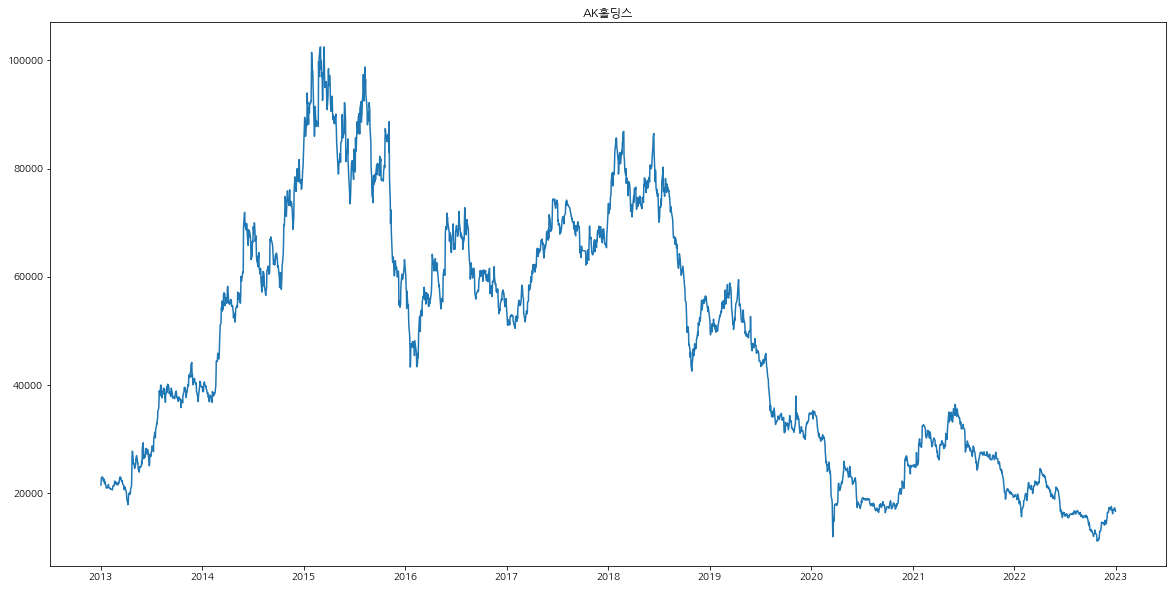

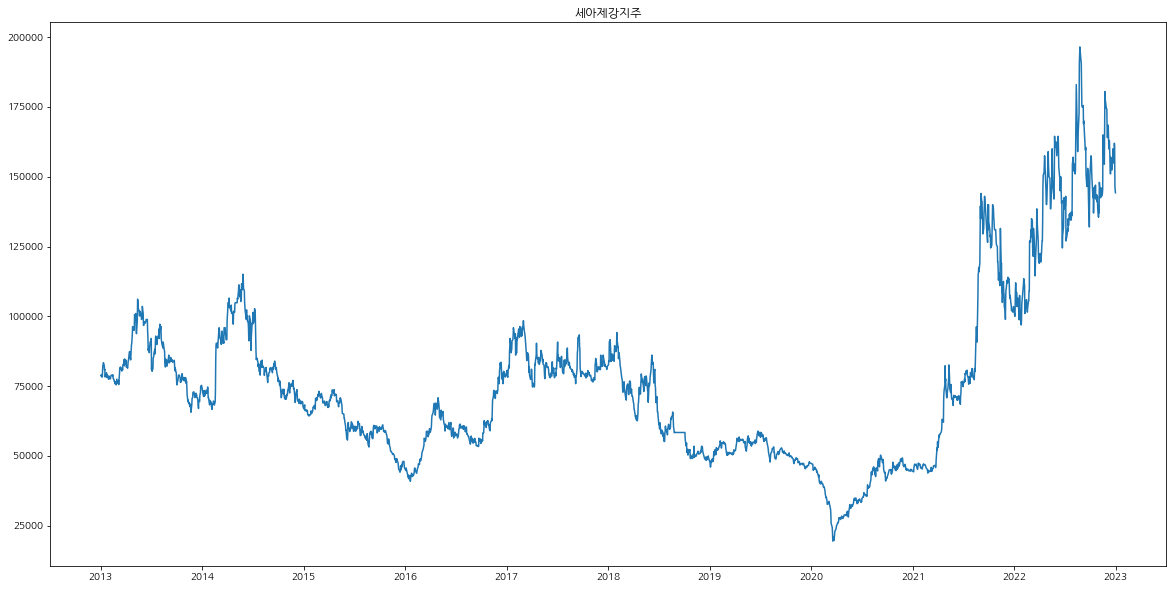

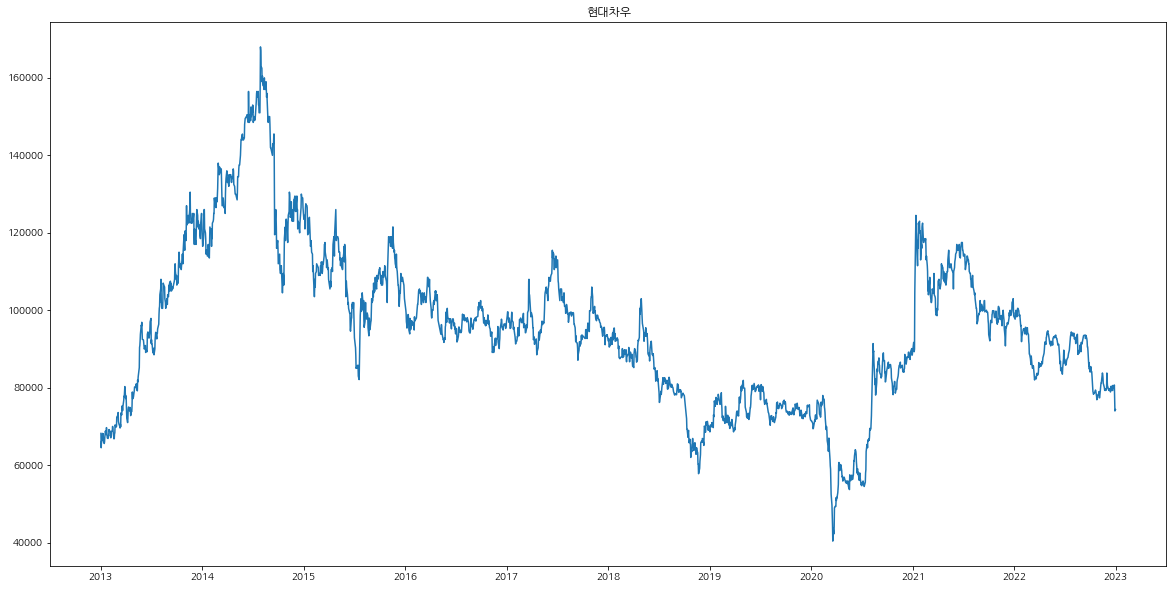

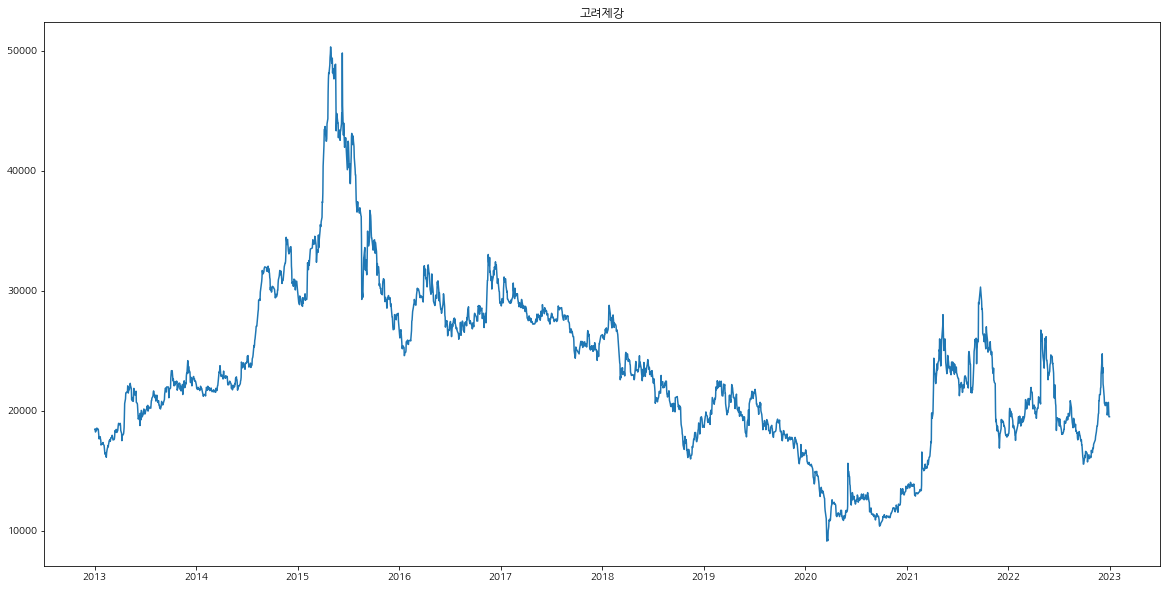

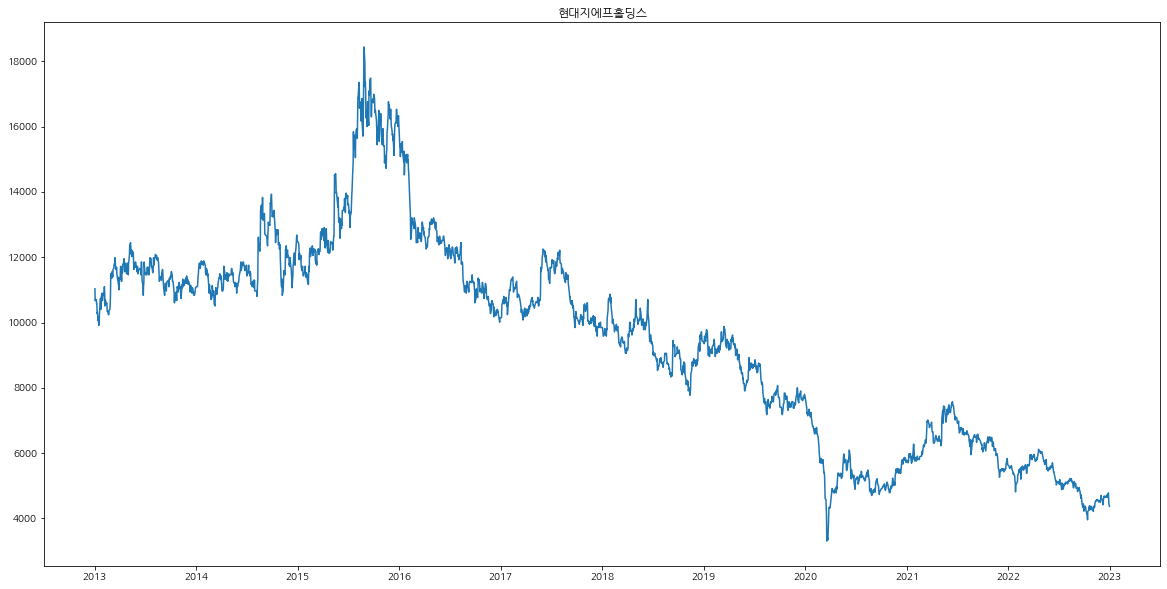

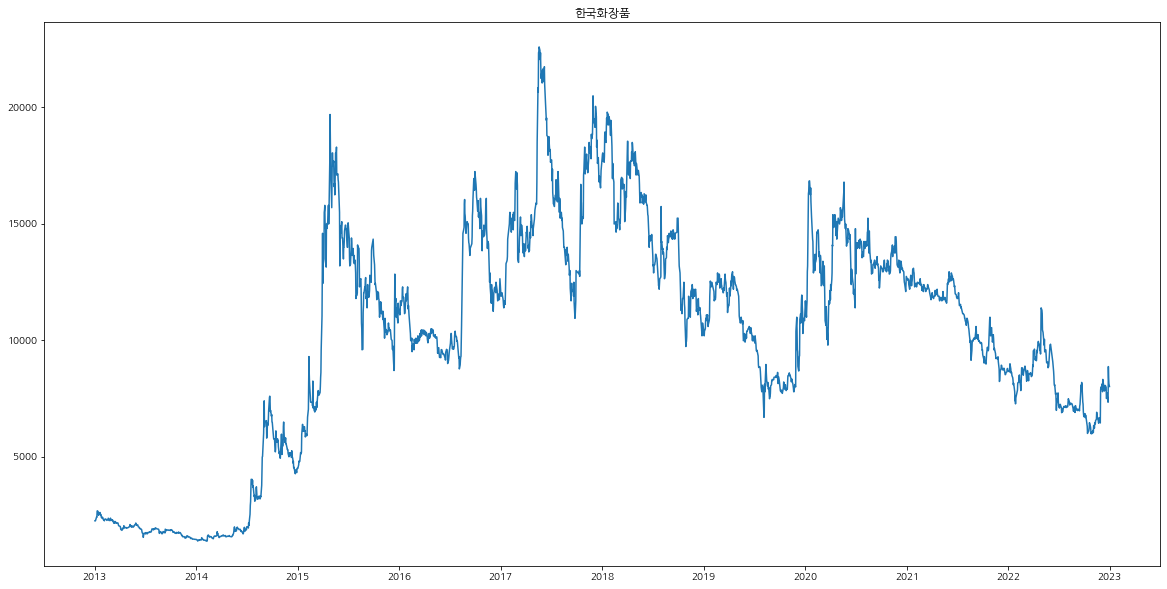

In [13]:
for i in range(df_stocks.shape[1]):
    plt.figure(figsize=(20, 10))
    plt.title(df_stocks.columns[i])
    plt.plot(df_stocks.iloc[:, i])
    plt.show()

In [15]:
## df, iw, ow, st, name
iw = 30
ow = 4
# for ow in [4, 7, 10, 15, 30]:  # output
for st in [3, 2, 1]:  # stride
    tmp_model, loss_list = forecasting_model(df_stocks, iw, ow, st)
    joblib.dump(tmp_model, './result/final2/clustering30/iw'+str(iw)+'_ow'+str(ow)+'_st'+str(st)+'_model.pkl')
    pd.DataFrame(loss_list, columns=['loss']).to_csv('./result/final2/clustering30/iw'+str(iw)+'_ow'+str(ow)+'_st'+str(st)+'_loss.csv')

iw=30 ow=4 st=3


100%|██████████████████████████████████████████████████████████████| 3000/3000 [2:16:33<00:00,  2.73s/it, loss=0.04800]


iw=30 ow=4 st=2


100%|██████████████████████████████████████████████████████████████| 3000/3000 [2:57:04<00:00,  3.54s/it, loss=0.05228]


iw=30 ow=4 st=1


100%|██████████████████████████████████████████████████████████████| 3000/3000 [4:57:21<00:00,  5.95s/it, loss=0.09515]
